In [70]:
import re
import random
import pandas as pd
import hashlib

In [71]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [72]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Logging in Python,275.741647,11.029666,25
Finance Junk,418.196479,69.699413,6
SharePoint,722.118349,42.477550,17
Azure Functions,744.553791,46.534612,16
Azure AI Search,846.302280,60.450163,14
Home Network Project,1128.785460,59.409761,19
Lost in a Good Book,1215.495630,60.774781,20
PP365,1227.852194,122.785219,10
Taxes,1264.024006,126.402401,10
Azure Functions + PP365,1379.489429,29.350839,47


# Histogram

49662.77


<Axes: >

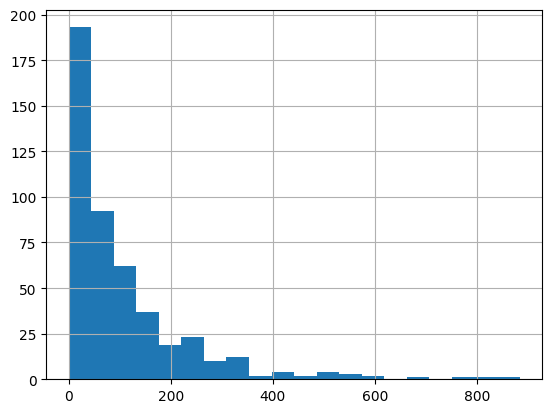

In [73]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [74]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [75]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [76]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [77]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [78]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [79]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [80]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [81]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [82]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [83]:
n = 6
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 469


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
429,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,-882.994613,110.818150,-882.994613,2548.817450,0.045389,0,0
428,Open Source/GitHub,"PEP 8\n\nPython Enhancement Proposal 8, the st...",b320da9e64259e5f42a9c7e954f15c67,-159.957956,110.818150,-882.994613,2548.817450,0.045389,1,0
427,Open Source/GitHub,GitHub Actions\n\nA feature on GitHub that all...,5281dc641160e7670129700c5b04176a,-144.150241,110.818150,-882.994613,2548.817450,0.045389,2,0
426,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,-129.869084,110.818150,-882.994613,2548.817450,0.045389,3,0
369,Open Source/GitHub,Issue Tracker\n\nA system within a repository ...,d49a9757f974d033bda963e7cc309367,-120.890685,110.818150,-882.994613,2548.817450,0.045389,4,0
425,Open Source/GitHub,Hotfix\n\nAn urgent fix applied to a project t...,07a66c6061571c256143d25116985a42,-120.014092,110.818150,-882.994613,2548.817450,0.045389,5,0
363,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,-810.619912,205.969554,-810.619912,3501.482416,0.736112,0,0
362,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,-507.941467,205.969554,-810.619912,3501.482416,0.736112,1,0
361,Email Auth and Security,ARC (Authenticated Received Chain)\n\nPreserve...,507b3fe94ee5aede9cf1a9ed228345dc,-505.535425,205.969554,-810.619912,3501.482416,0.736112,2,0
360,Email Auth and Security,p=reject\n\nA DMARC policy action.\nInstructs ...,d146dc2d7b2ea73dec474121100ef003,-294.860293,205.969554,-810.619912,3501.482416,0.736112,3,0


## Age Mean

In [84]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Card Count

In [85]:
# n=3
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



In [86]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
429,Open Source/GitHub,Semantic Versioning\n\nA versioning scheme tha...,9aef26d41b1623fdd93eaeef436024ea,-882.994613,110.818150,-882.994613,2548.817450,0.045389,0,0
428,Open Source/GitHub,"PEP 8\n\nPython Enhancement Proposal 8, the st...",b320da9e64259e5f42a9c7e954f15c67,-159.957956,110.818150,-882.994613,2548.817450,0.045389,1,0
427,Open Source/GitHub,GitHub Actions\n\nA feature on GitHub that all...,5281dc641160e7670129700c5b04176a,-144.150241,110.818150,-882.994613,2548.817450,0.045389,2,0
426,Open Source/GitHub,Good First Issue\n\nA label for beginner-frien...,ee4aff4c065b819d4ed6d2b8c3820ee9,-129.869084,110.818150,-882.994613,2548.817450,0.045389,3,0
369,Open Source/GitHub,Issue Tracker\n\nA system within a repository ...,d49a9757f974d033bda963e7cc309367,-120.890685,110.818150,-882.994613,2548.817450,0.045389,4,0
425,Open Source/GitHub,Hotfix\n\nAn urgent fix applied to a project t...,07a66c6061571c256143d25116985a42,-120.014092,110.818150,-882.994613,2548.817450,0.045389,5,0
363,Email Auth and Security,DKIM (DomainKeys Identified Mail)\n\nAn email ...,991e90ea49a5db4146ebabcbdc7fe747,-810.619912,205.969554,-810.619912,3501.482416,0.736112,0,0
362,Email Auth and Security,DMARC Analyzer\n\nA tool that helps organizati...,dba5d176e6856fc687767d9fcfd83d1c,-507.941467,205.969554,-810.619912,3501.482416,0.736112,1,0
361,Email Auth and Security,ARC (Authenticated Received Chain)\n\nPreserve...,507b3fe94ee5aede9cf1a9ed228345dc,-505.535425,205.969554,-810.619912,3501.482416,0.736112,2,0
360,Email Auth and Security,p=reject\n\nA DMARC policy action.\nInstructs ...,d146dc2d7b2ea73dec474121100ef003,-294.860293,205.969554,-810.619912,3501.482416,0.736112,3,0


In [87]:
existing_cards.head(10)['age'].sum()

-3676.8337673754995